# Imports etc.

In [1]:
import json
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)

In [2]:
# data_dir = 'C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/mTurk1'
data_dir = 'C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPP34'  # RPP3 is spring 2020; RPP4 is fall 2020
plot_dir = data_dir + 'figures'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Get data

## mTurk

In [3]:
def raw_data_row2pd(data_row):
    
    return pd.DataFrame(json.loads(data_row['trialdata']))

# # Use
# pd.concat([raw_data_row2pd(task_data_raw[i[0]]) for i in trial_data_rows])

In [4]:
def raw_data2rules_data_mturk(rule_row):
    
    # Get rules data
    rule_cols = ['middleRules', 'lowTransferRules', 'highTransferRules', 'highRules', 'taskVer', 'phaseNum']
    rules_dat = pd.DataFrame({rule_col: rule_row['trialdata'][rule_col] for rule_col in rule_cols})
    
    # Clean it up
    rules_dat = rules_dat.reset_index().rename(columns={'index': 'goal_id'})
    rules_dat['taskVer'] = rules_dat['taskVer'].replace({'A': 'high', 'B': 'low'})
    rules_dat = rules_dat.rename(columns={'middleRules': 'lowRules', 'taskVer': 'phase'})
    
    return rules_dat

# # Use
# pd.concat([raw_data2rules_data_mturk(rule_row) for rule_row in rule_rows])
# # raw_data2rules_data_mturk(rule_rows[0])

In [5]:
def get_all_mTurk_data(data_dir):
    
    # Read in and process data
    file_names = [f for f in os.listdir(data_dir) if '.json' in f]
    all_data_raw = pd.DataFrame()
    all_rules = pd.DataFrame()

    for sid, file_name in enumerate(file_names):

        # Read in raw data
        with open(os.path.join(data_dir, file_name)) as f:
            raw_data = json.load(f)

        # Get actual task data
        subj_data_raw = raw_data['data']

        trial_data_len = [len(subj_data_raw[i]['trialdata']) for i in range(len(subj_data_raw))]
        trial_data_rows = np.argwhere(np.array(trial_data_len) > 10000).flatten()  # rows with less than 10000 entries contain other stuff (e.g., rules)

        subj_data = pd.concat([raw_data_row2pd(subj_data_raw[i]) for i in trial_data_rows])

        # Add basic info
        subj_data['sid'] = sid
        subj_data['workerId'] = raw_data['workerId']
        subj_data['counterbalance'] = raw_data['counterbalance']
        subj_data['start_dateTime'] = raw_data['data'][0]['dateTime']
        subj_data['end_dateTime'] = raw_data['data'][-1]['dateTime']

        # Combine all subjects
        all_data_raw = pd.concat([all_data_raw, subj_data])

        # Get rule data
        rule_row_idx = np.argwhere(np.array(trial_data_len) == 21).flatten()  # trials with length 21 contain the rules
        rule_rows = [raw_data['data'][i] for i in rule_row_idx]

        subj_rules = pd.concat([raw_data2rules_data_mturk(rule_row) for rule_row in rule_rows])
        subj_rules['sid'] = sid

        all_rules = pd.concat([all_rules, subj_rules])

    return all_data_raw, all_rules

# # Use
# get_all_mTurk_data(data_dir)

## Get RPP data

In [6]:
def get_all_RPP_data(data_dir):

    file_names = [f for f in os.listdir(data_dir) if '.json' in f]

    all_data_raw = pd.DataFrame()
    for sid, file_name in enumerate(file_names):

        print("Reading in {}".format(file_name))

        # Get raw json
        subj_dat = pd.read_json(os.path.join(data_dir, file_name))
        
        # Add columns for sid, start and end time, phaseNum (which phase came first, which came second?)
        subj_dat['sid'] = int(file_name.split('_')[1][4:])
        subj_dat['testing_date'] = file_name.split('_')[2]
        subj_dat['start_dateTime'] = subj_dat.time_elapsed[subj_dat.time_elapsed.index[0]]
        subj_dat['end_dateTime'] = subj_dat.time_elapsed[subj_dat.time_elapsed.index[-1]]

        # Combine
        all_data_raw = pd.concat([all_data_raw, subj_dat])

    return all_data_raw
    
# # Use
# all_data_raw = get_all_RPP_data(data_dir)
# all_data_raw

In [7]:
def get_rule_data_rpp(all_data_raw):
    
    # Get raw rules data
    rule_rows = all_data_raw.highTransferRules.apply(lambda x : type(x) == dict)
    rule_cols = ['permKeys', 'permKeysOrder', 'permMiddleItems', 'permStars', 'middleRules', 'highRules',
                 'lowTransferRules', 'highTransferRules', 'taskVer', 'phaseNum', 'keys', 'letters',
                 'learnGoals', 'transferGoals']
    rule_data = all_data_raw.loc[rule_rows, ['sid'] + rule_cols].reset_index(drop=True)
    rule_data['taskVer'] = pd.Categorical(rule_data['taskVer']).rename_categories({'A': 'high', 'B': 'low'})
    rule_data = rule_data.rename(columns={'middleRules': 'lowRules', 'taskVer': 'phase'})
    
    return rule_data

# # Example use
# get_rule_data_rpp(all_data_raw)

In [8]:
def get_one_rule_rpp(rule_data, rule_col):
    
    r = rule_data[rule_col].apply(pd.Series)  # Split each cell (containing a dict) into several cells
    r[['sid', 'phase']] = rule_data[['sid', 'phase']]  # Get sid and phase for each row
    r = r.melt(id_vars=['sid', 'phase'], var_name='goal_id', value_name=rule_col)  # Melt
    
    return r

# # Use
# get_one_rule_rpp(rule_data, 'lowRules')

In [9]:
def clean_rule_data_rpp(rule_data_raw):
    
    # Select rule columns
    rule_cols_sub = ['sid', 'lowRules', 'highRules', 'lowTransferRules', 'highTransferRules', 'phase']
    rule_data_raw = rule_data_raw[rule_cols_sub]

    # Melt to split the dictionary across columns
    rule_cols = ['lowRules', 'highRules', 'lowTransferRules', 'highTransferRules']
    rule_data = get_one_rule_rpp(rule_data_raw, rule_cols[0])

    for rule_col in rule_cols[1:]:

        r = rule_data_raw[rule_col].apply(pd.Series)  # Split each cell (containing a dict) into several cells
        r[['sid', 'phase']] = rule_data_raw[['sid', 'phase']]  # Get sid and phase for each row
        r = r.melt(id_vars=['sid', 'phase'], var_name='goal_id', value_name=rule_col)  # Melt

        rule_data = pd.merge(rule_data, r, on=['sid', 'phase', 'goal_id'])

    return rule_data

# # Use
# clean_rule_data_rpp(rule_data_raw)

In [10]:
def msec2min(msec):
    
    sec = msec / 1000
    minutes = sec / 60
    return minutes

# Example use
s19 = 1806710 - 145800
s67 = 1913718 - 56652
msec2min(s19), msec2min(s67)

(27.681833333333334, 30.9511)

In [11]:
def clean_all_data(all_data_raw):

    # Add phaseNum column
    phasenum = all_data_raw.loc[np.invert(np.isnan(all_data_raw.phaseNum)), ['sid', 'taskVer', 'phaseNum']]
    all_data = pd.merge(
        all_data_raw.drop(columns=['taskVer', 'phaseNum'], axis=1), phasenum,
        left_on=['sid', 'phase'], right_on=['sid', 'taskVer'], how='outer'
    ).drop(columns=['taskVer'], axis=1)
    
    # Subset rows
    all_data = all_data.loc[all_data.trial_type.isin(['learning', 'transfer'])]  # remove instructions
    all_data = all_data.loc[all_data.subtrial.isin(range(4))]  # remove 5th (feedback) trial

    # Add more columns
    all_data['phase'] = all_data['phase'].replace({'A': 'high', 'B': 'low'})
    all_data['trial_'] = all_data['block'] * 25 + all_data['trial']  # get continuous trials over blocks
    all_data['duration'] = msec2min(all_data['end_dateTime'] - all_data['start_dateTime'])  # task duration

    # Add star iteration column
    all_data.loc[
        all_data.trial_type == 'learning', 'star_iteration'
    ] = all_data.loc[
        all_data.trial_type == 'learning', 'block'
    ].apply(lambda x : 0 if x <= 3 else (1 if x <= 7 else 2))
    all_data.loc[
        all_data.trial_type == 'transfer', 'star_iteration'
    ] = all_data.loc[
        all_data.trial_type == 'transfer', 'block'
    ].apply(lambda x : 0 if x <= 1 else (1 if x <= 3 else 2))
    
    # Add acc column (`correct` is only for successful star trials)
    acc_mask = all_data['subtrial'] == 3
    all_data.loc[acc_mask, 'acc'] = (all_data.loc[acc_mask, 'goal_star'] == all_data.loc[acc_mask, 'unlocked_star']).astype(int)
    all_data = all_data.reset_index(drop=True)
    
    return all_data

# # Use
# clean_all_data(all_data_raw)

## Read in data

In [12]:
if 'RPP' in data_dir:
    all_data_raw = get_all_RPP_data(data_dir)
    rule_data_raw = get_rule_data_rpp(all_data_raw)
    rule_data = clean_rule_data_rpp(rule_data_raw)
    
elif 'mTurk' in data_dir:
    all_data_raw, rule_data = get_all_mTurk_data(data_dir)

else:
    raise ValueError('Must be RPP or mTurk.')
    
all_data = clean_all_data(all_data_raw)
rule_data['goal_id'] = rule_data['goal_id'].apply(lambda x : int(x))
rule_data

Reading in CHaRLy_subj13885_2020-9-6_18_31.json
Reading in CHaRLy_subj14239_2020-7-22_22_51.json
Reading in CHaRLy_subj15670_2020-10-16_21_53.json
Reading in CHaRLy_subj16849_2020-9-14_0_45.json
Reading in CHaRLy_subj23638_2020-9-6_7_32.json
Reading in CHaRLy_subj24817_2020-9-5_19_32.json
Reading in CHaRLy_subj24964_2020-7-26_0_35.json
Reading in CHaRLy_subj24979_2020-7-24_15_5.json
Reading in CHaRLy_subj26179_2020-10-21_11_41.json
Reading in CHaRLy_subj26230_2020-7-23_18_32.json
Reading in CHaRLy_subj26641_2020-9-24_19_30.json
Reading in CHaRLy_subj26770_2020-9-6_16_5.json
Reading in CHaRLy_subj26899_2020-9-25_14_56.json
Reading in CHaRLy_subj27517_2020-9-25_13_21.json
Reading in CHaRLy_subj28033_2020-9-24_22_9.json
Reading in CHaRLy_subj28192_2020-10-16_21_20.json
Reading in CHaRLy_subj28525_2020-7-24_13_39.json
Reading in CHaRLy_subj31306_2020-7-24_23_51.json
Reading in CHaRLy_subj31438_2020-10-19_14_19.json
Reading in CHaRLy_subj31552_2020-9-5_15_57.json
Reading in CHaRLy_subj31684

,sid,phase,goal_id,lowRules,highRules,lowTransferRules,highTransferRules
0,13885,high,0,"[0, 1]","[3, 0]","[0, 1]","[3, 0]"
1,13885,low,0,"[1, 2]","[3, 2]","[0, 2]","[3, 2]"
2,14239,low,0,"[3, 0]","[1, 2]","[3, 1]","[1, 2]"
3,14239,high,0,"[3, 0]","[1, 0]","[3, 1]","[1, 3]"
4,15670,low,0,"[3, 0]","[3, 2]","[3, 1]","[3, 2]"
...,...,...,...,...,...,...,...
579,39514,high,3,"[1, 2]","[3, 0]","[0, 2]","[3, 2]"
580,39520,high,3,"[3, 0]","[0, 2]","[3, 1]","[3, 2]"
581,39520,low,3,"[2, 3]","[2, 0]","[2, 3]","[2, 0]"
582,39925,low,3,"[0, 1]","[2, 1]","[0, 1]","[2, 0]"


In [13]:
for level_a, level_b in zip(('low', 'high'), ('high', 'low')):
    
    # Add columns for rules that appear only in learning, only in transfer, and in both
    rule_data['{}RulesBoth'.format(level_a)] = rule_data.apply(
        lambda dat: dat['{}Rules'.format(level_a)]
            if dat['{}Rules'.format(level_a)] == dat['{}TransferRules'.format(level_a)]
            else np.nan, axis=1)
    rule_data['{}RulesLearnOnly'.format(level_a)] = rule_data.apply(
        lambda dat: dat['{}Rules'.format(level_a)]
            if dat['{}Rules'.format(level_a)] != dat['{}TransferRules'.format(level_a)]
            else np.nan, axis=1)
    rule_data['{}RulesTransferOnly'.format(level_a)] = rule_data.apply(
        lambda dat: dat['{}TransferRules'.format(level_a)]
            if dat['{}Rules'.format(level_a)] != dat['{}TransferRules'.format(level_a)]
            else np.nan, axis=1)
    
    # Get RulesBoth manually
    rule_data.loc[
        rule_data.phase == level_b,
        '{}RulesBoth'.format(level_a)
    ] = rule_data.loc[
        rule_data.phase == level_b,
        '{}Rules'.format(level_a)
    ]
    
    # Remove hypothetical, never-used transfer rules
    rule_data.loc[
        rule_data.phase == level_b,
        ['{}TransferRules'.format(level_a), '{}RulesTransferOnly'.format(level_a), '{}RulesLearnOnly'.format(level_a)]
    ] = np.nan
    
rule_data.loc[rule_data.phase == 'high']

,sid,phase,goal_id,lowRules,highRules,lowTransferRules,highTransferRules,lowRulesBoth,lowRulesLearnOnly,lowRulesTransferOnly,highRulesBoth,highRulesLearnOnly,highRulesTransferOnly
0,13885,high,0,"[0, 1]","[3, 0]",NaN,"[3, 0]","[0, 1]",NaN,NaN,"[3, 0]",NaN,NaN
3,14239,high,0,"[3, 0]","[1, 0]",NaN,"[1, 3]","[3, 0]",NaN,NaN,NaN,"[1, 0]","[1, 3]"
5,15670,high,0,"[3, 0]","[0, 3]",NaN,"[0, 3]","[3, 0]",NaN,NaN,"[0, 3]",NaN,NaN
6,16849,high,0,"[1, 2]","[3, 0]",NaN,"[2, 0]","[1, 2]",NaN,NaN,NaN,"[3, 0]","[2, 0]"
9,23638,high,0,"[0, 1]","[0, 2]",NaN,"[0, 2]","[0, 1]",NaN,NaN,"[0, 2]",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,39334,high,3,"[2, 3]","[2, 1]",NaN,"[2, 3]","[2, 3]",NaN,NaN,NaN,"[2, 1]","[2, 3]"
576,39508,high,3,"[0, 1]","[3, 1]",NaN,"[3, 1]","[0, 1]",NaN,NaN,"[3, 1]",NaN,NaN
579,39514,high,3,"[1, 2]","[3, 0]",NaN,"[3, 2]","[1, 2]",NaN,NaN,NaN,"[3, 0]","[3, 2]"
580,39520,high,3,"[3, 0]","[0, 2]",NaN,"[3, 2]","[3, 0]",NaN,NaN,NaN,"[0, 2]","[3, 2]"


In [14]:
rule_data.loc[rule_data.phase == 'low']

,sid,phase,goal_id,lowRules,highRules,lowTransferRules,highTransferRules,lowRulesBoth,lowRulesLearnOnly,lowRulesTransferOnly,highRulesBoth,highRulesLearnOnly,highRulesTransferOnly
1,13885,low,0,"[1, 2]","[3, 2]","[0, 2]",NaN,NaN,"[1, 2]","[0, 2]","[3, 2]",NaN,NaN
2,14239,low,0,"[3, 0]","[1, 2]","[3, 1]",NaN,NaN,"[3, 0]","[3, 1]","[1, 2]",NaN,NaN
4,15670,low,0,"[3, 0]","[3, 2]","[3, 1]",NaN,NaN,"[3, 0]","[3, 1]","[3, 2]",NaN,NaN
7,16849,low,0,"[3, 0]","[1, 3]","[3, 1]",NaN,NaN,"[3, 0]","[3, 1]","[1, 3]",NaN,NaN
8,23638,low,0,"[1, 2]","[0, 1]","[0, 2]",NaN,NaN,"[1, 2]","[0, 2]","[0, 1]",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,39334,low,3,"[1, 2]","[3, 2]","[0, 2]",NaN,NaN,"[1, 2]","[0, 2]","[3, 2]",NaN,NaN
577,39508,low,3,"[2, 3]","[0, 2]","[2, 3]",NaN,"[2, 3]",NaN,NaN,"[0, 2]",NaN,NaN
578,39514,low,3,"[1, 2]","[3, 2]","[0, 2]",NaN,NaN,"[1, 2]","[0, 2]","[3, 2]",NaN,NaN
581,39520,low,3,"[2, 3]","[2, 0]","[2, 3]",NaN,"[2, 3]",NaN,NaN,"[2, 0]",NaN,NaN


In [15]:
rule_data.to_csv(os.path.join(data_dir, 'rule_data.csv'))

## Add hypothetical middle-level items and stars to all_data

In [16]:
def get_goal_rule(trial_rules, goal_id, rule_name):
    
    goal_rule = trial_rules.loc[trial_rules['goal_id'] == goal_id, rule_name]
    return goal_rule[goal_rule.index[0]]

# # Use
# get_goal_rule(trial_rules, goal_id, 'lowRules')

In [17]:
def actions2items(trial_rules, actions, low_rule_name):
    
    items = 4 * [np.nan]

    for goal_id in trial_rules.goal_id:
        goal_rule = get_goal_rule(trial_rules, goal_id, low_rule_name)
        
        for i, action_tuple in enumerate([np.array(actions[:2]), np.array(actions[2:])]):
            if np.all(action_tuple == goal_rule):
                items[2 * i + 1] = int(goal_id)

    return items
        
# # Use
# actions = [3, 0, 2, 3]
# actions = [3, 1, 2, 3]
# actions2items(trial_rules, actions, 'lowRules')

In [18]:
def items2stars(trial_rules, items, high_rule_name):

    for goal_id in trial_rules.goal_id:

        goal_rule = get_goal_rule(trial_rules, goal_id, high_rule_name)
        comp_items = np.array([items[1], items[3]])

        # Valid sequence of two items
        if np.all(goal_rule == comp_items):
            return 3 * [np.nan,] + [int(goal_id)]

    # No valid sequence of two items
    return 4 * [np.nan,]
        
# # Use
# items = [np.nan, 1, np.nan, 2]
# items2stars(trial_rules, items, high_rule_name)

In [19]:
# Add a column for each rule (takes a LONG time)
for i, sid in enumerate(set(all_data.sid)):
    print(' sid: {}/{}'.format(i, len(set(all_data.sid))))
    
    for trial_type in set(all_data.trial_type):
        print('  trial_type: {}'.format(trial_type))
        
        for phase in set(all_data.phase):
            print('   phase: {}'.format(phase))

            # Get rules for this sid and this phase
            trial_rules = rule_data.loc[
                (rule_data.sid == sid) & (rule_data.phase == phase)
            ]
            
            if trial_rules.shape[0] > 0:

                for block in set(all_data.block):

                    for trial in set(all_data.trial):

                        all_data_mask = (all_data.sid == sid) & (all_data.phase == phase) & (
                            all_data.trial_type == trial_type) & (all_data.block == block) & (all_data.trial == trial)

                        # Get actions and items for this sid, this phase, this trial_type, this block, and this trial
                        trial_dat = all_data.loc[all_data_mask]
                        actions = trial_dat.action_id
                        items = list(trial_dat.middle_item_name)

                        if trial_dat.shape[0] == 4:  # Make sure we have 4 valid trials

                            for rule_name in [c for c in rule_data.columns if 'Rules' in c]:
                                if 'low' in rule_name:

                                    pred_middle_items = actions2items(trial_rules, actions, rule_name)
                                    all_data.loc[all_data_mask, 'middle_item_' + rule_name] = pred_middle_items

                                if 'high' in rule_name:

                                    pred_star = items2stars(trial_rules, items, rule_name)
                                    all_data.loc[all_data_mask, 'unlocked_star_' + rule_name] = pred_star

 sid: 0/73
  trial_type: learning
   phase: high
   phase: low
  trial_type: transfer
   phase: high
   phase: low
 sid: 1/73
  trial_type: learning
   phase: high
   phase: low
  trial_type: transfer
   phase: high
   phase: low
 sid: 2/73
  trial_type: learning
   phase: high
   phase: low
  trial_type: transfer
   phase: high
   phase: low
 sid: 3/73
  trial_type: learning
   phase: high
   phase: low
  trial_type: transfer
   phase: high
   phase: low
 sid: 4/73
  trial_type: learning
   phase: high
   phase: low
  trial_type: transfer
   phase: high
   phase: low
 sid: 5/73
  trial_type: learning
   phase: high
   phase: low
  trial_type: transfer
   phase: high
   phase: low
 sid: 6/73
  trial_type: learning
   phase: high
   phase: low
  trial_type: transfer
   phase: high
   phase: low
 sid: 7/73
  trial_type: learning
   phase: high
   phase: low
  trial_type: transfer
   phase: high
   phase: low
 sid: 8/73
  trial_type: learning
   phase: high
   phase: low
  trial_type: tra

   phase: low
 sid: 71/73
  trial_type: learning
   phase: high
   phase: low
  trial_type: transfer
   phase: high
   phase: low
 sid: 72/73
  trial_type: learning
   phase: high
   phase: low
  trial_type: transfer
   phase: high
   phase: low


In [20]:
# Verifie that assigning theoretical items and stars was accurate
learn_data = all_data.loc[(all_data.trial_type == 'learning') & np.invert(np.isnan(all_data.middle_item_name))]
np.mean(learn_data.middle_item_name == learn_data.middle_item_lowRules)

cols = ['sid', 'phase', 'trial_type', 'trial_', 'trial', 'subtrial', 'block', 'middle_item_name', 'middle_item_lowRules', 'unlocked_star_name', 'unlocked_star_highRules']
learn_data.loc[learn_data.middle_item_name != learn_data.middle_item_lowRules, cols]

learn_data = all_data.loc[(all_data.trial_type == 'learning') & np.invert(np.isnan(all_data.unlocked_star_name))
                          & np.invert(all_data.unlocked_star_name == -1)
                         ]
np.mean(learn_data.unlocked_star_name == learn_data.unlocked_star_highRules)
learn_data.loc[learn_data.unlocked_star_name != learn_data.unlocked_star_highRules, cols]

,sid,phase,trial_type,trial_,trial,subtrial,block,middle_item_name,middle_item_lowRules,unlocked_star_name,unlocked_star_highRules


In [21]:
# Boolean indicator for when items / stars would have appeared for each set of rules (lowRules, lowTransferRules, highRules, highTransferRules)
goals_cols = [
    'middle_item_lowRules', 'middle_item_lowTransferRules',
    'unlocked_star_highRules', 'unlocked_star_highTransferRules',
    'middle_item_lowRulesBoth', 'middle_item_lowRulesLearnOnly', 'middle_item_lowRulesTransferOnly',
    'unlocked_star_highRulesBoth', 'unlocked_star_highRulesLearnOnly', 'unlocked_star_highRulesTransferOnly',
    
]

for col in goals_cols:
    all_data['bool_{}'.format(col)] = np.invert(np.isnan(all_data[col])).astype(int)

# Add columns

## Log RTs

In [22]:
all_data['log_rt'] = np.log(1 + all_data['rt'])

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 382'. Pick better value with 'binwidth'.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\layer.py:372: PlotnineWarning: stat_bin : Removed 1254 rows containing non-finite values.


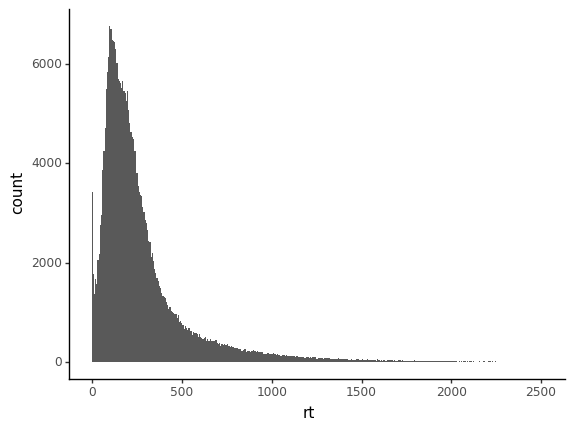

<ggplot: (167968735519)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 248'. Pick better value with 'binwidth'.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\layer.py:372: PlotnineWarning: stat_bin : Removed 1254 rows containing non-finite values.


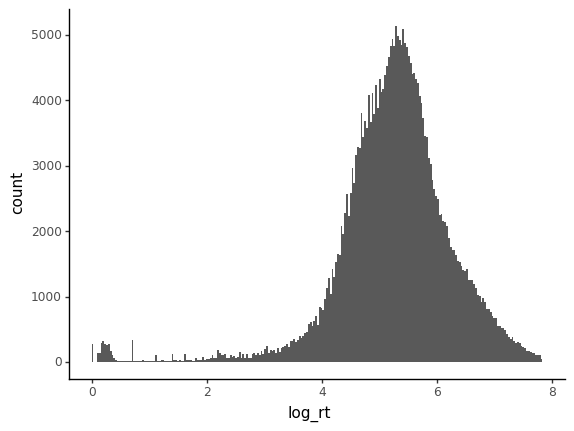

<ggplot: (167973302173)>


In [23]:
g = (gg.ggplot(all_data, gg.aes('rt'))
     + gg.geom_histogram()
    )
print(g)

g = (gg.ggplot(all_data, gg.aes('log_rt'))
     + gg.geom_histogram()
    )
print(g)

## Acc column that is filled in for each subtrial, not just for subtrial==3

In [24]:
old_all_data_shape = all_data.shape

id_cols = ['sid', 'phase', 'trial_type', 'block', 'trial', 'trial_']
acc_dat = all_data.groupby(id_cols).aggregate('mean').reset_index()
all_data = pd.merge(all_data.drop(columns=['acc']), acc_dat[id_cols + ['acc']], on=id_cols)
assert all_data.shape == old_all_data_shape
all_data

,rt,stimulus,key_press,trial_type,trial_index,time_elapsed,internal_node_id,phase,block,trial,...,bool_unlocked_star_highRules,bool_unlocked_star_highTransferRules,bool_middle_item_lowRulesBoth,bool_middle_item_lowRulesLearnOnly,bool_middle_item_lowRulesTransferOnly,bool_unlocked_star_highRulesBoth,bool_unlocked_star_highRulesLearnOnly,bool_unlocked_star_highRulesTransferOnly,log_rt,acc
0,797.865,0,85.0,learning,297,2422963,0.0-77.0-0.0,high,0.0,0.0,...,0,0,0,0,0,0,0,0,6.683192,0.0
1,654.720,0,73.0,learning,298,2423619,0.0-77.0-1.0,high,0.0,0.0,...,0,0,1,0,0,0,0,0,6.485734,0.0
2,1317.900,0,79.0,learning,299,2424938,0.0-77.0-2.0,high,0.0,0.0,...,0,0,0,0,0,0,0,0,7.184553,0.0
3,276.305,0,80.0,learning,300,2425216,0.0-77.0-3.0,high,0.0,0.0,...,0,0,0,0,0,0,0,0,5.625118,0.0
4,823.310,0,85.0,learning,302,2426546,0.0-78.0-0.0,high,0.0,1.0,...,0,0,0,0,0,0,0,0,6.714547,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288789,220.350,0,87.0,transfer,5305,2269108,0.0-1118.0-3.0,high,7.0,23.0,...,0,0,0,0,0,0,0,0,5.399745,0.0
288790,302.075,0,81.0,transfer,5307,2269929,0.0-1119.0-0.0,high,7.0,24.0,...,0,0,0,0,0,0,0,0,5.713980,0.0
288791,196.285,0,69.0,transfer,5308,2270132,0.0-1119.0-1.0,high,7.0,24.0,...,0,0,1,0,0,0,0,0,5.284649,0.0
288792,328.075,0,81.0,transfer,5309,2270467,0.0-1119.0-2.0,high,7.0,24.0,...,0,0,0,0,0,0,0,0,5.796286,0.0


## Bool middle item

In [25]:
all_data['bool_middle_item'] =  np.invert(np.isnan(all_data['middle_item'])) * (all_data['middle_item'] != -1)
all_data['bool_star'] =  np.invert(np.isnan(all_data['unlocked_star'])) * (all_data['unlocked_star'] != -1)
all_data[['middle_item', 'bool_middle_item', 'unlocked_star', 'acc', 'bool_star']]

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\pandas\core\computation\expressions.py:200: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\pandas\core\computation\expressions.py:200: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead


,middle_item,bool_middle_item,unlocked_star,acc,bool_star
0,NaN,False,NaN,0.0,False
1,0.0,True,NaN,0.0,False
2,NaN,False,NaN,0.0,False
3,-1.0,False,-1.0,0.0,False
4,NaN,False,NaN,0.0,False
...,...,...,...,...,...
288789,-1.0,False,-1.0,0.0,False
288790,NaN,False,NaN,0.0,False
288791,1.0,True,NaN,0.0,False
288792,NaN,False,NaN,0.0,False


## Add non_items

In [26]:
id_cols = ['sid', 'phase', 'trial_type', 'block', 'trial']
no_item_sub = all_data.loc[
    np.invert(all_data['bool_middle_item']),
    id_cols + ['action_id', 'subtrial']
]
no_item_sub['subtrial'] = no_item_sub['subtrial'].astype(int)
no_item_sub[:30]

,sid,phase,trial_type,block,trial,action_id,subtrial
0,13885,high,learning,0.0,0.0,0.0,0
2,13885,high,learning,0.0,0.0,3.0,2
3,13885,high,learning,0.0,0.0,2.0,3
4,13885,high,learning,0.0,1.0,0.0,0
5,13885,high,learning,0.0,1.0,2.0,1
6,13885,high,learning,0.0,1.0,3.0,2
7,13885,high,learning,0.0,1.0,1.0,3
8,13885,high,learning,0.0,2.0,0.0,0
9,13885,high,learning,0.0,2.0,3.0,1
10,13885,high,learning,0.0,2.0,1.0,2


In [27]:
no_item_w = no_item_sub.pivot_table(index=id_cols, columns=['subtrial'], values=['action_id']).reset_index()
no_item_w.columns = [''.join([str(e) for e in f]) for f in no_item_w.columns.values]
no_item_w

,sid,phase,trial_type,block,trial,action_id0,action_id1,action_id2,action_id3
0,13885,high,learning,0.0,0.0,0.0,NaN,3.0,2.0
1,13885,high,learning,0.0,1.0,0.0,2.0,3.0,1.0
2,13885,high,learning,0.0,2.0,0.0,3.0,1.0,NaN
3,13885,high,learning,0.0,3.0,3.0,1.0,0.0,2.0
4,13885,high,learning,0.0,4.0,3.0,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
72995,39925,low,transfer,7.0,20.0,0.0,NaN,2.0,NaN
72996,39925,low,transfer,7.0,21.0,3.0,2.0,1.0,0.0
72997,39925,low,transfer,7.0,22.0,1.0,3.0,1.0,3.0
72998,39925,low,transfer,7.0,23.0,3.0,NaN,-1.0,NaN


In [28]:
def get_not_items(x, not_items = {4: [2, 0], 5: [3, 1], 6: [0, 3], 7: [2, 1], 8: [0, 2], 9: [1, 0], 10: [3, 2], 11: [1, 3]}):
    
    if np.isnan(x[0]) | np.isnan(x[1]):
        return np.nan
    
    else:
        for middle_item, keys in not_items.items():
            if keys == [x[0], x[1]]:
                return middle_item
        else:
            return np.nan
    
# # Example use
# get_not_items([0, 2]), get_not_items([3, 2]), get_not_items([0, 1]), get_not_items([0, np.nan])

In [29]:
no_item_w['middle_item1'] = no_item_w[['action_id0', 'action_id1']].apply(get_not_items, axis=1)
no_item_w['middle_item3'] = no_item_w[['action_id2', 'action_id3']].apply(get_not_items, axis=1)
no_item_w

,sid,phase,trial_type,block,trial,action_id0,action_id1,action_id2,action_id3,middle_item1,middle_item3
0,13885,high,learning,0.0,0.0,0.0,NaN,3.0,2.0,NaN,10.0
1,13885,high,learning,0.0,1.0,0.0,2.0,3.0,1.0,8.0,5.0
2,13885,high,learning,0.0,2.0,0.0,3.0,1.0,NaN,6.0,NaN
3,13885,high,learning,0.0,3.0,3.0,1.0,0.0,2.0,5.0,8.0
4,13885,high,learning,0.0,4.0,3.0,2.0,1.0,0.0,10.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...
72995,39925,low,transfer,7.0,20.0,0.0,NaN,2.0,NaN,NaN,NaN
72996,39925,low,transfer,7.0,21.0,3.0,2.0,1.0,0.0,10.0,9.0
72997,39925,low,transfer,7.0,22.0,1.0,3.0,1.0,3.0,11.0,11.0
72998,39925,low,transfer,7.0,23.0,3.0,NaN,-1.0,NaN,NaN,NaN


In [30]:
no_item_l = no_item_w[id_cols + ['middle_item1', 'middle_item3']
                     ].melt(id_vars=id_cols, var_name='subtrial', value_name='middle_item')
no_item_l['subtrial'] = no_item_l['subtrial'].apply(lambda x : int(x[-1]))
no_item_l

,sid,phase,trial_type,block,trial,subtrial,middle_item
0,13885,high,learning,0.0,0.0,1,NaN
1,13885,high,learning,0.0,1.0,1,8.0
2,13885,high,learning,0.0,2.0,1,6.0
3,13885,high,learning,0.0,3.0,1,5.0
4,13885,high,learning,0.0,4.0,1,10.0
...,...,...,...,...,...,...,...
145995,39925,low,transfer,7.0,20.0,3,NaN
145996,39925,low,transfer,7.0,21.0,3,9.0
145997,39925,low,transfer,7.0,22.0,3,11.0
145998,39925,low,transfer,7.0,23.0,3,NaN


In [31]:
id_cols = ['sid', 'phase', 'trial_type', 'block', 'trial', 'subtrial']
all_data = pd.merge(all_data, no_item_l, how='outer', on=id_cols, suffixes=['', '_not'])
all_data['middle_item_both'] = all_data[['middle_item', 'middle_item_not']].apply(lambda x : x[0] if x[0] > -1 else x[1], axis=1)
all_data[id_cols + ['middle_item', 'middle_item_not', 'middle_item_both']][:30]

,sid,phase,trial_type,block,trial,subtrial,middle_item,middle_item_not,middle_item_both
0,13885,high,learning,0.0,0.0,0.0,NaN,NaN,NaN
1,13885,high,learning,0.0,0.0,1.0,0.0,NaN,0.0
2,13885,high,learning,0.0,0.0,2.0,NaN,NaN,NaN
3,13885,high,learning,0.0,0.0,3.0,-1.0,10.0,10.0
4,13885,high,learning,0.0,1.0,0.0,NaN,NaN,NaN
5,13885,high,learning,0.0,1.0,1.0,-1.0,8.0,8.0
6,13885,high,learning,0.0,1.0,2.0,NaN,NaN,NaN
7,13885,high,learning,0.0,1.0,3.0,-1.0,5.0,5.0
8,13885,high,learning,0.0,2.0,0.0,NaN,NaN,NaN
9,13885,high,learning,0.0,2.0,1.0,-1.0,6.0,6.0


## Add star_inplace columns

In [47]:
# REMEMBER! RULE_DATA REFERS TO ACTION_ID -> MIDDLE_ITEM_NAME; AND MIDDLE_ITEM_NAME -> UNLOCKED_STAR_NAME
all_data[['sid', 'phase', 'trial_type', 'trial', 'subtrial', 'acc', 'action_id', 'middle_item_name', 'unlocked_star_name']]

,sid,phase,trial_type,trial,subtrial,acc,action_id,middle_item_name,unlocked_star_name
0,13885,high,learning,0.0,0.0,0.0,0.0,NaN,NaN
1,13885,high,learning,0.0,1.0,0.0,1.0,0.0,NaN
2,13885,high,learning,0.0,2.0,0.0,3.0,NaN,NaN
3,13885,high,learning,0.0,3.0,0.0,2.0,NaN,-1.0
4,13885,high,learning,1.0,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
290975,39925,low,transfer,23.0,3.0,NaN,NaN,NaN,NaN
286797,39925,low,transfer,24.0,0.0,0.0,3.0,NaN,NaN
286798,39925,low,transfer,24.0,1.0,0.0,1.0,1.0,NaN
286799,39925,low,transfer,24.0,2.0,0.0,2.0,NaN,NaN


In [48]:
for item in range(4):
    all_data['count_item{}'.format(item)] = all_data['middle_item_name'] == item
    
for star in range(4):
    all_data['count_star{}'.format(star)] = all_data['unlocked_star_name'] == star
    
all_data

,rt,stimulus,key_press,trial_type,trial_index,time_elapsed,internal_node_id,phase,block,trial,...,middle_item_not,middle_item_both,count_item0,count_item1,count_item2,count_item3,count_star0,count_star1,count_star2,count_star3
0,797.865,0,85.0,learning,297.0,2422963.0,0.0-77.0-0.0,high,0.0,0.0,...,NaN,NaN,False,False,False,False,False,False,False,False
1,654.720,0,73.0,learning,298.0,2423619.0,0.0-77.0-1.0,high,0.0,0.0,...,NaN,0.0,True,False,False,False,False,False,False,False
2,1317.900,0,79.0,learning,299.0,2424938.0,0.0-77.0-2.0,high,0.0,0.0,...,NaN,NaN,False,False,False,False,False,False,False,False
3,276.305,0,80.0,learning,300.0,2425216.0,0.0-77.0-3.0,high,0.0,0.0,...,10.0,10.0,False,False,False,False,False,False,False,False
4,823.310,0,85.0,learning,302.0,2426546.0,0.0-78.0-0.0,high,0.0,1.0,...,NaN,NaN,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290975,NaN,NaN,NaN,transfer,NaN,NaN,NaN,low,7.0,23.0,...,NaN,NaN,False,False,False,False,False,False,False,False
286797,884.860,0,79.0,transfer,2790.0,1240253.0,0.0-595.0-0.0,low,7.0,24.0,...,NaN,NaN,False,False,False,False,False,False,False,False
286798,203.660,0,80.0,transfer,2791.0,1240463.0,0.0-595.0-1.0,low,7.0,24.0,...,NaN,3.0,False,True,False,False,False,False,False,False
286799,262.600,0,73.0,transfer,2792.0,1240731.0,0.0-595.0-2.0,low,7.0,24.0,...,NaN,NaN,False,False,False,False,False,False,False,False


In [49]:
id_cols = ['sid', 'phase', 'trial_type', 'block']
count_cols = ['count_item{}'.format(i) for i in range(4)] + ['count_star{}'.format(s) for s in range(4)]

all_data = all_data.sort_values(['sid', 'trial_type', 'phase', 'block', 'trial', 'subtrial'])
new_columns = all_data[id_cols + count_cols].groupby(id_cols).cumsum()
all_data = all_data.drop(columns=count_cols).join(new_columns)
all_data

,rt,stimulus,key_press,trial_type,trial_index,time_elapsed,internal_node_id,phase,block,trial,...,middle_item_not,middle_item_both,count_item0,count_item1,count_item2,count_item3,count_star0,count_star1,count_star2,count_star3
0,797.865,0,85.0,learning,297.0,2422963.0,0.0-77.0-0.0,high,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1,654.720,0,73.0,learning,298.0,2423619.0,0.0-77.0-1.0,high,0.0,0.0,...,NaN,0.0,1,0,0,0,0,0,0,0
2,1317.900,0,79.0,learning,299.0,2424938.0,0.0-77.0-2.0,high,0.0,0.0,...,NaN,NaN,1,0,0,0,0,0,0,0
3,276.305,0,80.0,learning,300.0,2425216.0,0.0-77.0-3.0,high,0.0,0.0,...,10.0,10.0,1,0,0,0,0,0,0,0
4,823.310,0,85.0,learning,302.0,2426546.0,0.0-78.0-0.0,high,0.0,1.0,...,NaN,NaN,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290975,NaN,NaN,NaN,transfer,NaN,NaN,NaN,low,7.0,23.0,...,NaN,NaN,10,1,1,11,3,0,0,0
286797,884.860,0,79.0,transfer,2790.0,1240253.0,0.0-595.0-0.0,low,7.0,24.0,...,NaN,NaN,10,1,1,11,3,0,0,0
286798,203.660,0,80.0,transfer,2791.0,1240463.0,0.0-595.0-1.0,low,7.0,24.0,...,NaN,3.0,10,2,1,11,3,0,0,0
286799,262.600,0,73.0,transfer,2792.0,1240731.0,0.0-595.0-2.0,low,7.0,24.0,...,NaN,NaN,10,2,1,11,3,0,0,0


In [98]:
def get_sid_phase_star_rules(all_data_row, star_id):

    rule = rule_data.loc[
        (rule_data['phase'] == all_data_row['phase']) & (rule_data['sid'] == all_data_row['sid']) & (rule_data['goal_id'] == star_id),
        ['highRules']
    ]
#     rule_string = rule.values[0][0]
#     rule_int = [int(n[1]) for n in rule_string.split(',')]
    
#     return rule_int
    return rule.values[0][0]

# Example use
get_sid_phase_star_rules(all_data.loc[0], star_id=0), get_sid_phase_star_rules(all_data.loc[0], star_id=1)

test_dat = all_data[:30]
test_dat['star_rule'] = test_dat.apply(get_sid_phase_star_rules, star_id=1, axis=1)
test_dat

<ipython-input-98-7c04a03c056d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,rt,stimulus,key_press,trial_type,trial_index,time_elapsed,internal_node_id,phase,block,trial,...,middle_item_both,count_item0,count_item1,count_item2,count_item3,count_star0,count_star1,count_star2,count_star3,star_rule
0,797.865,0,85.0,learning,297.0,2422963.0,0.0-77.0-0.0,high,0.0,0.0,...,NaN,0,0,0,0,0,0,0,0,"[0, 1]"
1,654.720,0,73.0,learning,298.0,2423619.0,0.0-77.0-1.0,high,0.0,0.0,...,0.0,1,0,0,0,0,0,0,0,"[0, 1]"
2,1317.900,0,79.0,learning,299.0,2424938.0,0.0-77.0-2.0,high,0.0,0.0,...,NaN,1,0,0,0,0,0,0,0,"[0, 1]"
3,276.305,0,80.0,learning,300.0,2425216.0,0.0-77.0-3.0,high,0.0,0.0,...,10.0,1,0,0,0,0,0,0,0,"[0, 1]"
4,823.310,0,85.0,learning,302.0,2426546.0,0.0-78.0-0.0,high,0.0,1.0,...,NaN,1,0,0,0,0,0,0,0,"[0, 1]"
5,239.845,0,80.0,learning,303.0,2426787.0,0.0-78.0-1.0,high,0.0,1.0,...,8.0,1,0,0,0,0,0,0,0,"[0, 1]"
6,389.015,0,79.0,learning,304.0,2427178.0,0.0-78.0-2.0,high,0.0,1.0,...,NaN,1,0,0,0,0,0,0,0,"[0, 1]"
7,298.555,0,73.0,learning,305.0,2427480.0,0.0-78.0-3.0,high,0.0,1.0,...,5.0,1,0,0,0,0,0,0,0,"[0, 1]"
8,42.995,0,85.0,learning,307.0,2428032.0,0.0-79.0-0.0,high,0.0,2.0,...,NaN,1,0,0,0,0,0,0,0,"[0, 1]"
9,344.920,0,79.0,learning,308.0,2428380.0,0.0-79.0-1.0,high,0.0,2.0,...,6.0,1,0,0,0,0,0,0,0,"[0, 1]"


In [99]:
def get_star_inplace(all_data_row):
    
    has_item0 = (all_data_row['count_item{}'.format(all_data_row['star_rule'][0])] > 0)
    has_item1 = (all_data_row['count_item{}'.format(all_data_row['star_rule'][1])] > 0)
    
    return has_item0 & has_item1

# Example use
test_dat.apply(get_star_inplace, axis=1)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23     True
24     True
25     True
26     True
27     True
28     True
29     True
dtype: bool

In [100]:
for star_id in range(4):
    
    print("Star {}".format(star_id))
    
    all_data['star_rule'] = all_data.apply(get_sid_phase_star_rules, star_id=star_id, axis=1)
    all_data['star{}_inplace'.format(star_id)] = all_data.apply(get_star_inplace, axis=1)

all_data

Star 0
Star 1
Star 2
Star 3


,rt,stimulus,key_press,trial_type,trial_index,time_elapsed,internal_node_id,phase,block,trial,...,count_item3,count_star0,count_star1,count_star2,count_star3,star_rule,star0_inplace,star1_inplace,star2_inplace,star3_inplace
0,797.865,0,85.0,learning,297.0,2422963.0,0.0-77.0-0.0,high,0.0,0.0,...,0,0,0,0,0,"[2, 3]",False,False,False,False
1,654.720,0,73.0,learning,298.0,2423619.0,0.0-77.0-1.0,high,0.0,0.0,...,0,0,0,0,0,"[2, 3]",False,False,False,False
2,1317.900,0,79.0,learning,299.0,2424938.0,0.0-77.0-2.0,high,0.0,0.0,...,0,0,0,0,0,"[2, 3]",False,False,False,False
3,276.305,0,80.0,learning,300.0,2425216.0,0.0-77.0-3.0,high,0.0,0.0,...,0,0,0,0,0,"[2, 3]",False,False,False,False
4,823.310,0,85.0,learning,302.0,2426546.0,0.0-78.0-0.0,high,0.0,1.0,...,0,0,0,0,0,"[2, 3]",False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290975,NaN,NaN,NaN,transfer,NaN,NaN,NaN,low,7.0,23.0,...,11,3,0,0,0,"[2, 1]",True,True,True,True
286797,884.860,0,79.0,transfer,2790.0,1240253.0,0.0-595.0-0.0,low,7.0,24.0,...,11,3,0,0,0,"[2, 1]",True,True,True,True
286798,203.660,0,80.0,transfer,2791.0,1240463.0,0.0-595.0-1.0,low,7.0,24.0,...,11,3,0,0,0,"[2, 1]",True,True,True,True
286799,262.600,0,73.0,transfer,2792.0,1240731.0,0.0-595.0-2.0,low,7.0,24.0,...,11,3,0,0,0,"[2, 1]",True,True,True,True


## Save to csv

In [101]:
all_data.to_csv(os.path.join(data_dir, 'all_data_raw.csv'))